In [1]:
#

In [1]:
import pandas as pd                         # 데이터 분석 패키지
import numpy as np                          # 계산 패키지
import matplotlib.pyplot as plt             # 데이터 시각화 패키지
import seaborn as sns                       # 데이터 시각화 패키지

import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import pandas as pd

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [4]:
test.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


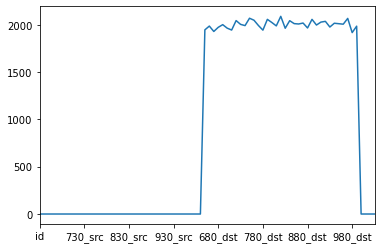

In [5]:
# train 데이터 결측치 확인

train.isna().sum().plot()

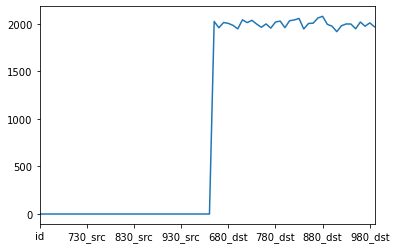

In [6]:
# test 데이터 결측치 확인

test.isna().sum().plot()

In [7]:
# 결측치 처리 (결측치 -> 평균값)

test = test.fillna(train.mean())
train = train.fillna(train.mean())

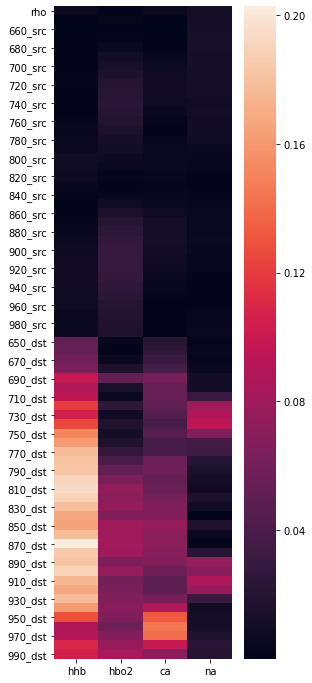

In [8]:
# 데이터 시각화
# 데이터와 hho, hbo2, ca, na의 상관관계 분석
# 비교적 상관관계가 큰 dst컬럼을 feature로 선정

plt.figure(figsize=(4, 12))
sns.heatmap(train.corr().loc['rho':'990_dst', 'hhb':].abs())

In [9]:
x_train = train.loc[:, '650_dst':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 35), (10000, 4))

In [11]:
x_train.head()

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,1.341997e-11,0.000000e+00,1.872129e-11,0.000000e+00,...,7.976805e-11,3.527371e-18,6.687656e-11,6.455564e-19,7.511190e-11,0.000000e+00,2.498465e-11,1.067504e-18,5.998949e-18,4.378513e-17
1,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.872129e-11,0.000000e+00,...,2.647633e-09,6.761949e-11,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,4.047717e-11,9.710091e-09,2.364072e-10
2,1.677445e-19,3.763590e-20,7.149459e-12,0.000000e+00,5.830921e-12,9.800478e-12,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,2.364072e-10
3,4.044975e-11,1.049022e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,1.478769e-11,1.583839e-10,1.940671e-11,...,1.274876e-10,6.118947e-11,6.687656e-11,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,4.047717e-11,4.088921e-10,2.364072e-10
4,4.784751e-14,1.049022e-11,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,...,0.000000e+00,6.761949e-11,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,2.498465e-11,1.330237e-13,1.153774e-10,2.364072e-10


In [12]:
y_train.head()

,hhb,hbo2,ca,na
0,5.59,4.32,8.92,4.29
1,0.00,2.83,7.25,4.64
2,10.64,3.00,8.40,5.16
3,5.67,4.01,5.05,4.35
4,11.97,4.41,10.78,2.42


In [13]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'seed':777
            }

        model = xgb.train(params=params, dtrain=d_train, num_boost_round=500, verbose_eval=500, evals=wlist)
        models.append(model)
    
    return models

In [14]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

train column :  hhb
[0]	train-mae:5.32221	eval-mae:5.30458
[499]	train-mae:0.04192	eval-mae:1.86661
[0]	train-mae:5.32727	eval-mae:5.26705
[499]	train-mae:0.03752	eval-mae:1.85421
[0]	train-mae:5.32278	eval-mae:5.30720
[499]	train-mae:0.03859	eval-mae:1.92132
[0]	train-mae:5.31354	eval-mae:5.35914
[499]	train-mae:0.03790	eval-mae:1.88682
[0]	train-mae:5.31246	eval-mae:5.37954
[499]	train-mae:0.03681	eval-mae:1.85131
train column :  hbo2
[0]	train-mae:2.46025	eval-mae:2.47400
[499]	train-mae:0.01887	eval-mae:0.79524
[0]	train-mae:2.45931	eval-mae:2.47805
[499]	train-mae:0.01860	eval-mae:0.80273
[0]	train-mae:2.46738	eval-mae:2.42502
[499]	train-mae:0.01904	eval-mae:0.82043
[0]	train-mae:2.45922	eval-mae:2.47788
[499]	train-mae:0.02011	eval-mae:0.81112
[0]	train-mae:2.46275	eval-mae:2.45569
[499]	train-mae:0.01980	eval-mae:0.80811
train column :  ca
[0]	train-mae:5.99717	eval-mae:6.09502
[499]	train-mae:0.04762	eval-mae:2.34335
[0]	train-mae:6.00470	eval-mae:6.02908
[499]	train-mae:0.049

In [15]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(xgb.DMatrix(test.loc[:, '650_dst':])))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [16]:
submission.head()

,id,hhb,hbo2,ca,na
0,10000,7.672807,3.994872,9.086050,3.092227
1,10001,5.597369,4.154807,8.262137,2.093462
2,10002,10.586995,4.555421,11.061234,3.867779
3,10003,8.480302,4.129624,10.989163,3.177399
4,10004,8.713501,2.920488,8.031573,4.157152


In [17]:
submission.to_csv('Dacon_200613_1.csv', index=False)